### Библиотеки

In [53]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'
sns.set_style("darkgrid")

import sys
sys.path.append('../data')

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go

import statsmodels.api as sm
import statsmodels.tsa.api as smt

### Данные

In [54]:
def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [55]:
raw_data = pd.read_csv('../data/features_df.csv')
raw_data['Timestamp'] = pd.to_datetime(raw_data['Timestamp'])
#raw_data = raw_data.drop(columns=['Date'], axis=1)
#raw_data = raw_data[~((raw_data['Income'] == 0) & (raw_data['Outcome'] == 0))]
#raw_data = raw_data[raw_data['Timestamp'].dt.year >= 2020]
data = pd.DataFrame(raw_data.set_index('Timestamp'))

In [56]:
data

,tax_day,lag_outcome_1,rolling_mean_7,rolling_mean_14,week_day_0,week_day_2,week_day_3,week_day_5,month_2,month_4,month_5,month_8,month_11,month_12,Balance
Timestamp,,,,,,,,,,,,,,,
2017-01-27,0,1.112359,-0.075413,-0.036247,0,0,0,0,0,0,0,0,0,0,-0.199300
2017-01-30,0,1.395696,-0.086055,-0.040138,1,0,0,0,0,0,0,0,0,0,-0.157799
2017-01-31,0,1.461531,-0.107828,-0.042439,0,0,0,0,0,0,0,0,0,0,-0.027000
2017-02-01,0,1.287402,-0.095414,-0.044923,0,1,0,0,1,0,0,0,0,0,0.093309
2017-02-02,0,0.860194,-0.066463,-0.095174,0,0,1,0,1,0,0,0,0,0,0.083316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-25,1,2.528054,-0.470248,-0.426045,0,0,1,0,0,0,0,0,0,0,-0.869018
2021-03-26,0,3.173234,-0.521035,-0.489058,0,0,0,0,0,0,0,0,0,0,-2.514887
2021-03-29,0,4.687433,-0.821994,-0.669633,1,0,0,0,0,0,0,0,0,0,-1.013855


In [57]:
plotly_df(data)

In [58]:
sm.tsa.stattools.adfuller(data['Balance'])[1]

np.float64(2.7753691059058675e-05)

In [59]:
sm.tsa.stattools.kpss(data['Balance'])

(np.float64(2.6407815287869916),
 np.float64(0.01),
 13,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [60]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))


        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])


        plt.tight_layout()

Критерий Дики-Фуллера: p=0.000028


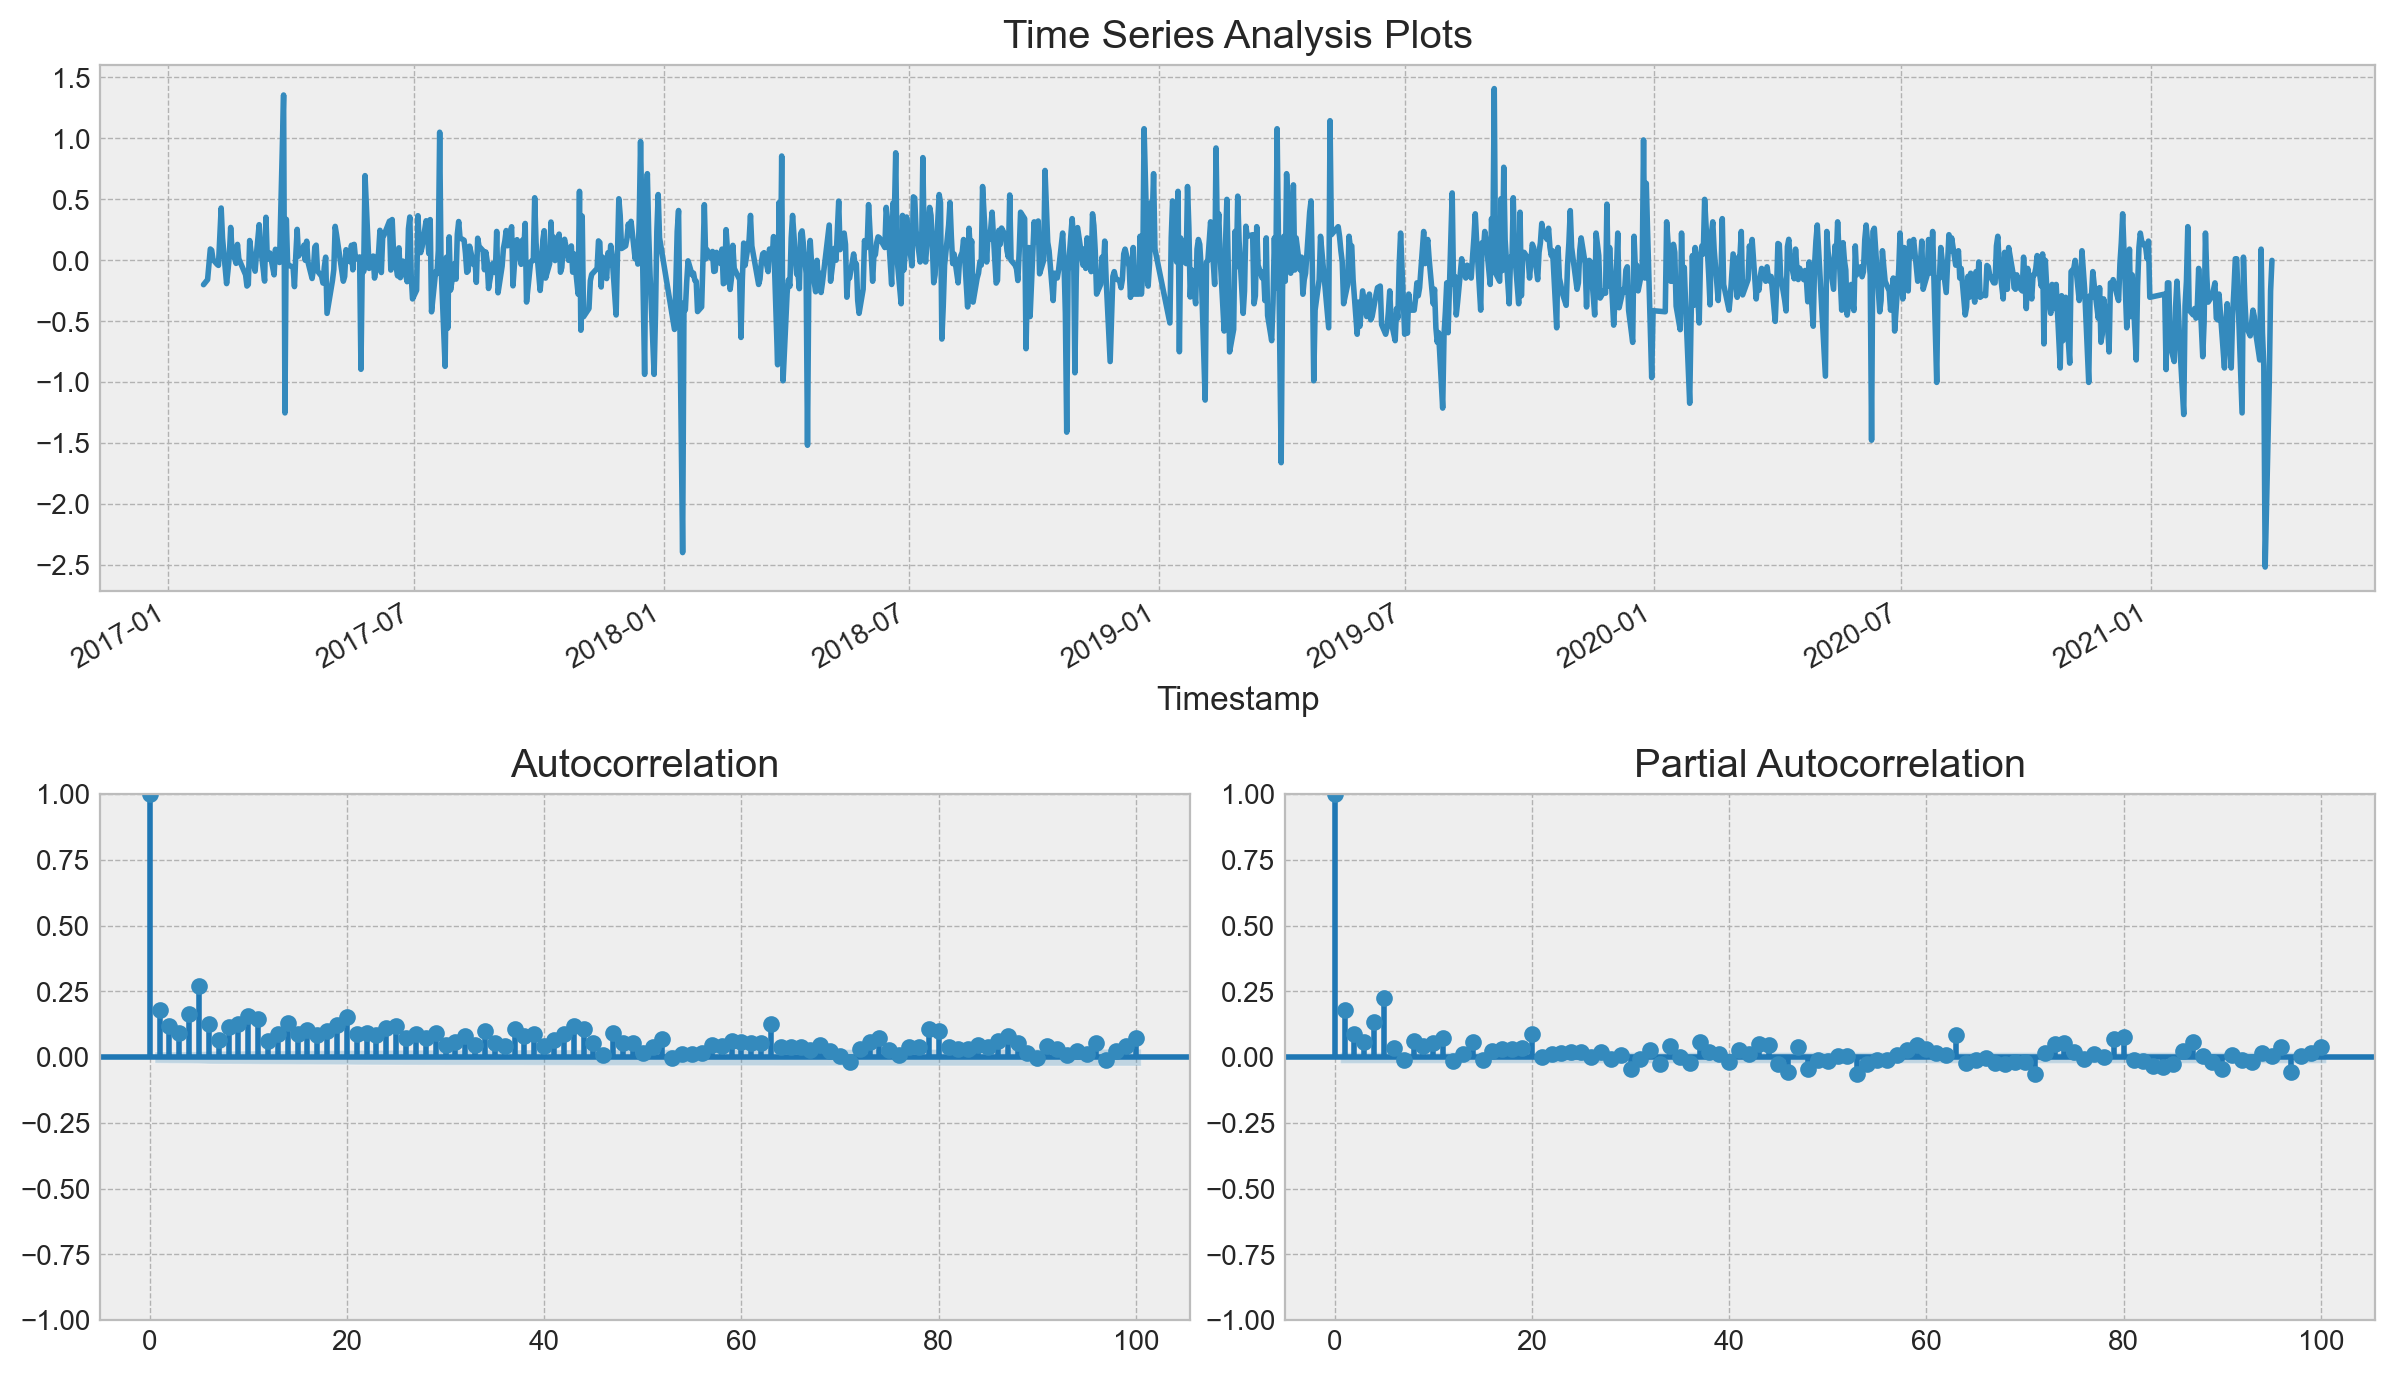

In [61]:
tsplot(data['Balance'], lags=100)
plt.show()

In [62]:
ps = range(0, 8)
d=0
qs = range(0, 8)
Ps = range(0, 1)
D=0
Qs = range(0, 1)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

64

In [63]:
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [71]:
data.dtypes

tax_day              int64
lag_outcome_1      float64
rolling_mean_7     float64
rolling_mean_14    float64
week_day_0           int64
week_day_2           int64
week_day_3           int64
week_day_5           int64
month_2              int64
month_4              int64
month_5              int64
month_8              int64
month_11             int64
month_12             int64
Balance            float64
dtype: object

In [77]:
%%time
results = []
best_aic = float("inf")
#warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(
            data['Balance'],
            exog=data[[
                'tax_day', 
                'lag_outcome_1', 
                'rolling_mean_7', 
                'rolling_mean_14',
                'week_day_0', 
                'week_day_2',
                'week_day_3', 
                'week_day_5', 
                'month_2',
                'month_4', 
                'month_5', 
                'month_8', 
                'month_11', 
                'month_12'
            ]],
            order=(param[0], d, param[1]),
            seasonal_order=(param[2], D, param[3], 5)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

#warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']

100%|██████████| 64/64 [01:10<00:00,  1.10s/it]

CPU times: user 1min 10s, sys: 781 ms, total: 1min 10s
Wall time: 1min 10s


In [78]:
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
31  (3, 7, 0, 0)  552.249214
47  (5, 7, 0, 0)  553.623617
61  (7, 5, 0, 0)  555.262287
37  (4, 5, 0, 0)  560.758949
20  (2, 4, 0, 0)  561.832194


In [79]:
param = (3, 7, 0, 0)

model=sm.tsa.statespace.SARIMAX(data['Balance'][-200:],
                                exog=data[[
                                    'tax_day', 
                                    'lag_outcome_1', 
                                    'rolling_mean_7', 
                                    'rolling_mean_14',
                                    'week_day_0', 
                                    'week_day_2',
                                    'week_day_3', 
                                    'week_day_5', 
                                    'month_2',
                                    'month_4', 
                                    'month_5', 
                                    'month_8', 
                                    'month_11', 
                                    'month_12'
                                ]][-200:],
                                order=(param[0], d, param[1]),
                                seasonal_order=(param[2], D, param[3], 5)).fit(disp=-1)

In [81]:
tsplot(model.resid[5:], lags=30)
plt.plot()

Критерий Дики-Фуллера: p=0.000000


[]

In [82]:
pred = model.predict(start = data.index[-200], end = data.index[-1])

In [83]:
pred

Timestamp
2020-06-09   -0.195706
2020-06-10   -0.296460
2020-06-11   -0.191974
2020-06-15   -0.310473
2020-06-16   -0.317342
                ...   
2021-03-25   -0.570851
2021-03-26   -0.676137
2021-03-29   -0.911713
2021-03-30   -0.631651
2021-03-31   -0.446203
Name: predicted_mean, Length: 200, dtype: float64

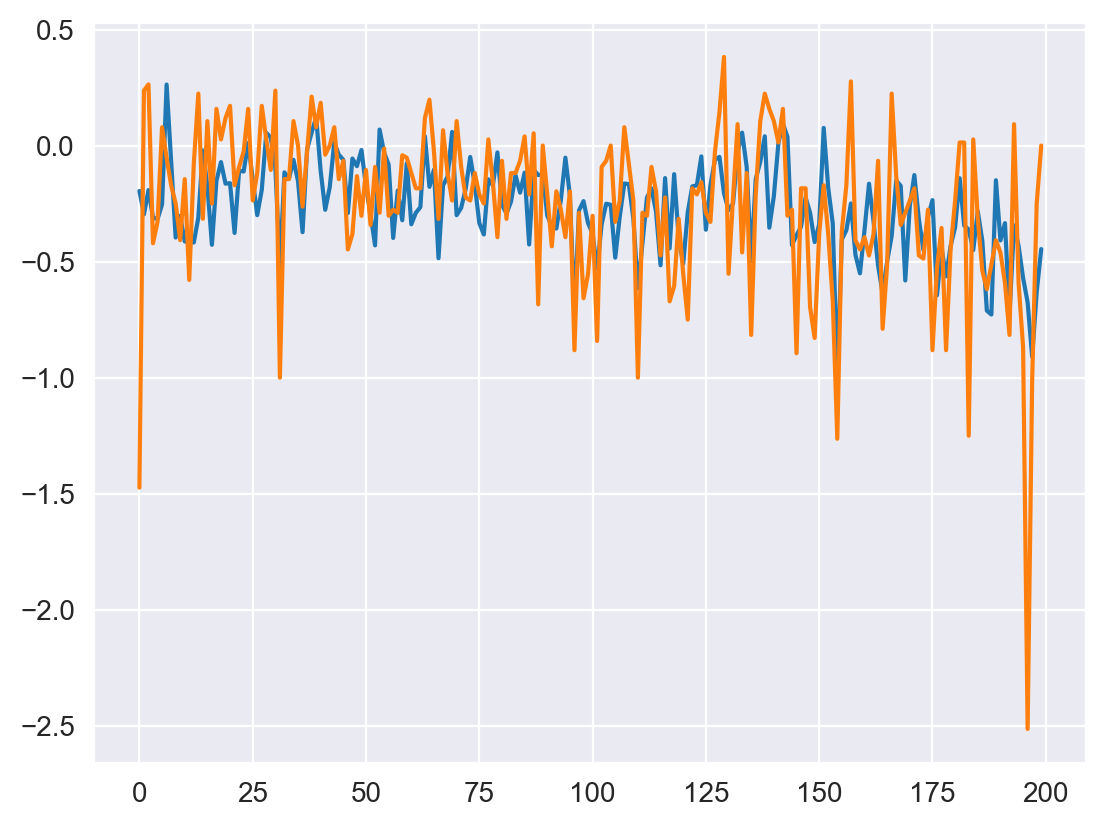

In [86]:
plt.plot(pred.values)
plt.plot(data['Balance'][-200:].values)
plt.show()

In [87]:
df = pd.concat([pd.DataFrame(pred), pd.DataFrame(data['Balance'][-200:])], axis=1)

In [88]:
plotly_df(df)

In [89]:
df['erros'] = df['predicted_mean'] - df['Balance']

In [90]:
np.mean(np.abs(df['erros']))

np.float64(0.20598075107487293)

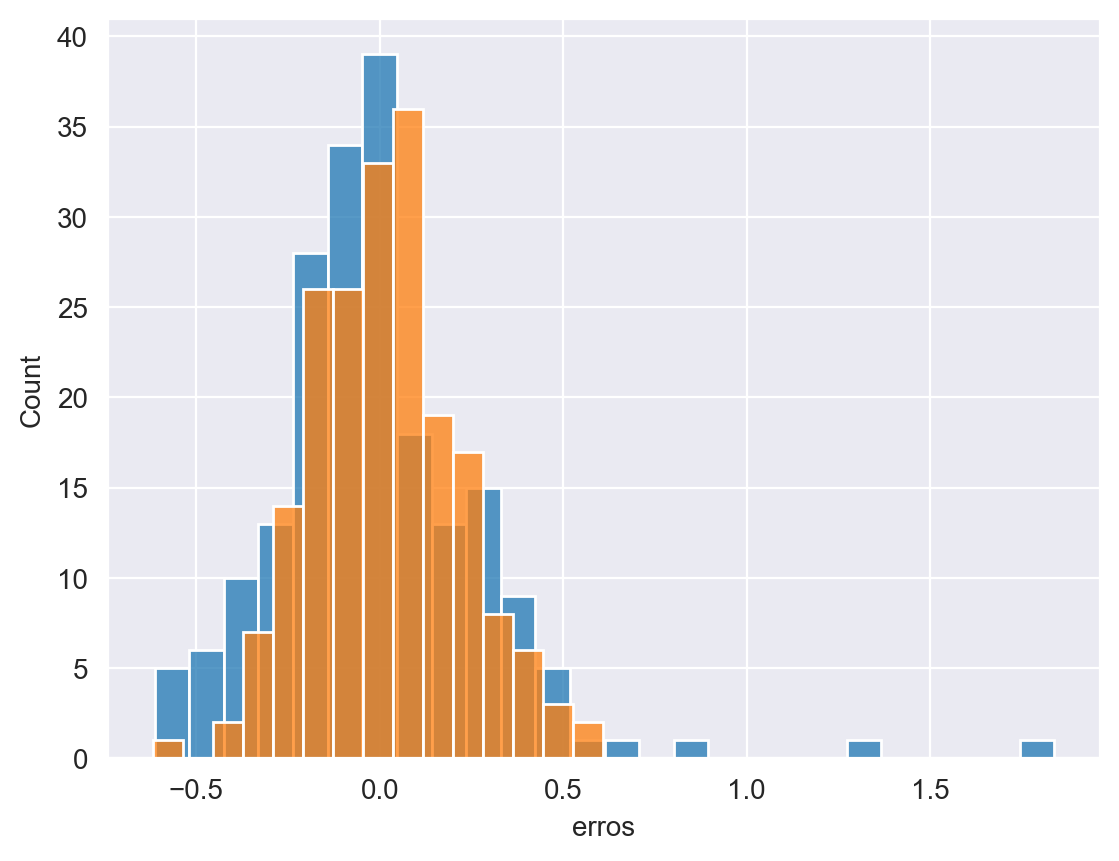

In [97]:
sns.histplot(df['erros'])
sns.histplot(np.random.normal(0, 0.2, 200))
plt.show()

In [98]:
rng = np.random.default_rng()
stats.kstest(np.random.normal(0, 0.2, 200), df['erros'])

KstestResult(statistic=np.float64(0.09), pvalue=np.float64(0.39352743357720954), statistic_location=np.float64(0.2579399909411049), statistic_sign=np.int8(1))

In [143]:
sample1

array([-1.18507859, -0.43538085, -0.05236737,  0.41052422,  0.0700492 ,
        0.53679309,  0.07246233, -0.17572284,  2.60061176, -0.17201683,
       -0.19353471, -0.09765802,  3.13227133,  0.55779716, -2.33115925,
        0.15186653, -3.02652648, -1.5789562 ,  0.08540319,  1.11466757,
       -1.95732381,  0.35347975, -2.27023319, -1.09714445,  1.16862362,
        0.55998621, -1.55680667, -0.57033049, -0.44740493,  0.28691188,
        0.19971148, -0.34145906,  2.10108791, -1.27944434,  0.94573762,
       -0.08098674,  0.07106248,  0.19608373, -0.01473285, -3.10243616,
       -0.23444063,  2.62266792, -0.7925767 , -1.05754242,  2.54268124,
       -1.76414924,  0.20045888,  0.29583731,  1.81225461,  0.66562965,
       -3.22788947, -0.88557133, -2.10072254, -1.29987529,  0.8673531 ,
        0.86413065,  0.89949618, -1.21026416,  1.25759744,  0.00969788,
       -0.10822773,  0.52530861, -0.22602601,  2.38260608, -1.75287938,
       -1.41153113, -2.96324215, -1.90476468,  3.16022237, -2.25

In [131]:
sns.histplot(np.array())

TypeError: array() missing required argument 'object' (pos 0)

In [96]:
from scipy import stats

In [116]:
stats.kstest(df['erros'].clip(-1, 1), "norm")

KstestResult(statistic=np.float64(0.2600517924960557), pvalue=np.float64(2.025428081919524e-12), statistic_location=np.float64(0.4815810578579367), statistic_sign=np.int8(1))

In [91]:
pred_ = pred.values
true = data['Balance'][-200:].values

np.abs(true - pred).mean()

np.float64(0.2787409905875124)

In [ ]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                Balance   No. Observations:                  912
Model:               SARIMAX(1, 0, 7)   Log Likelihood                -256.326
Date:                Thu, 17 Apr 2025   AIC                            530.651
Time:                        17:10:27   BIC                            573.992
Sample:                             0   HQIC                           547.197
                                - 912                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9720      0.023     42.057      0.000       0.927       1.017
ma.L1         -0.9137      0.038    -24.179      0.000      -0.988      -0.840
ma.L2         -0.0046      0.041     -0.112      0.9

In [ ]:
forecast = model.get_forecast(steps=30)

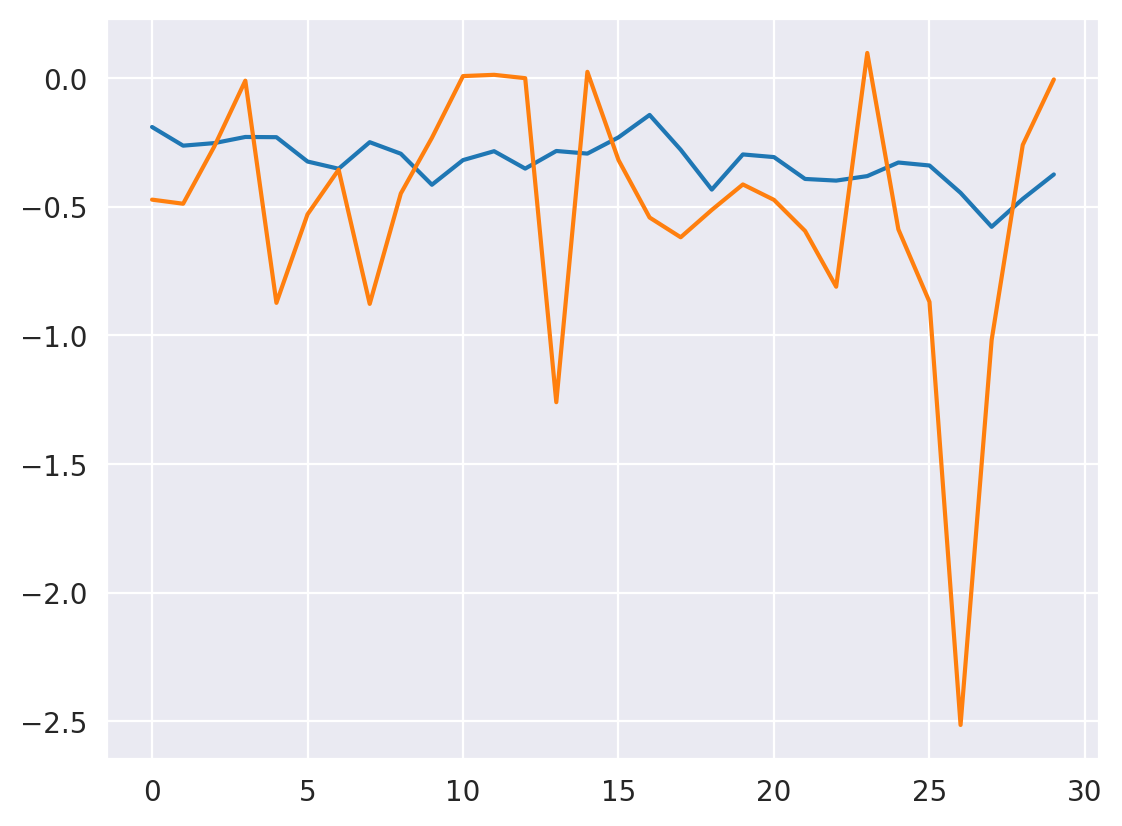

In [ ]:
plt.plot(preds)
plt.plot(data['Balance'][-30:].values)

In [ ]:
import pandas as pd
import statsmodels.api as sm

# Предположим, у вас есть DataFrame df с временным рядом
# df должен иметь колонку с датой/временем в качестве индекса
# и колонку с целевой переменной, например 'value'

# Пример данных (если у вас их нет):
# index = pd.date_range(start='2020-01-01', periods=100, freq='M')
# df = pd.DataFrame({'value': np.random.randn(100)}, index=index)

# Параметры SARIMAX (подберите свои оптимальные параметры)
order = (1, 1, 1)          # (p, d, q) - параметры AR, дифференцирования, MA
seasonal_order = (1, 1, 1, 12)  # (P, D, Q, S) - сезонные параметры и период сезонности

# Создание и обучение модели
model = sm.tsa.statespace.SARIMAX(
    df['value'],            # целевая переменная
    order=order,            # несезонные параметры
    seasonal_order=seasonal_order,  # сезонные параметры
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Обучение модели
results = model.fit(disp=False)  # disp=False отключает лишний вывод

# Вывод сводки по модели
print(results.summary())

# Прогнозирование на n шагов вперед
n_forecast = 12  # например, прогноз на 12 периодов вперед
forecast = results.get_forecast(steps=n_forecast)

# Получение прогноза и доверительных интервалов
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Визуализация
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['value'], label='Исторические данные')
plt.plot(forecast_mean.index, forecast_mean, label='Прогноз', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('Прогноз SARIMAX')
plt.show()